By [Kevin Michalewicz](https://kevinmichalewicz.com) on May 2023

This notebook discusses feature interpretation in the context of NMA-CNN.

In [1]:
# General imports
import cv2
import glob
import itertools
import os
import pandas as pd
import numpy as np
import subprocess
import torch

from copy import deepcopy
from matplotlib.colors import CenteredNorm

# for reading and displaying images
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch-related libraries
from adabelief_pytorch import AdaBelief

# NMA-CNN
from nmacnn.model.model import NormalModeAnalysisCNN
from nmacnn.preprocessing.preprocessing import Preprocessing
from nmacnn.utils.torch_utils import load_checkpoint

# Loading results

In [2]:
# Parameters
modes = 30
n_filters = 2
filter_size = 5
pooling_size = 1
n_max_epochs = 40
mode = 'fully-extended' # Choose between 'fully-extended' and 'fully-cropped'
pathological = ['5omm', '1mj7', '1qfw', '1qyg', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t']
stage = 'predicting'
test_dccm_map_path = '../notebooks/test_data/dccm_map/'
test_residues_path = '../notebooks/test_data/list_of_residues/'
test_structure_path = '../notebooks/test_data/structure/'

# Pre-processing
preprocessed_data = Preprocessing(chain_lengths_path='chain_lengths_paired/', dccm_map_path='dccm_maps_paired/', residues_path='lists_of_residues_paired/', modes=modes, pathological=pathological, mode=mode, stage=stage, test_dccm_map_path=test_dccm_map_path, test_residues_path=test_residues_path, test_structure_path=test_structure_path)
input_shape = preprocessed_data.test_x.shape[-1]

# Loading the actual checkpoint and learnt filters
path = '../checkpoints/model_epochs_' + str(n_max_epochs) + '_modes_' + str(modes) + '_pool_' + str(pooling_size) + '_filters_' + str(n_filters) + '_size_' + str(filter_size) + '.pt'
model = load_checkpoint(path, input_shape)[0]
learnt_filter = np.load('../checkpoints/learnt_filter_epochs_'+str(n_max_epochs)+'_modes_'+str(modes)+'_pool_'+str(pooling_size)+'_filters_'+str(n_filters)+'_size_'+str(filter_size)+'.npy')
model.eval()

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


NormalModeAnalysisCNN(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=89042, out_features=1, bias=False)
)

# Obtaining maps of interest

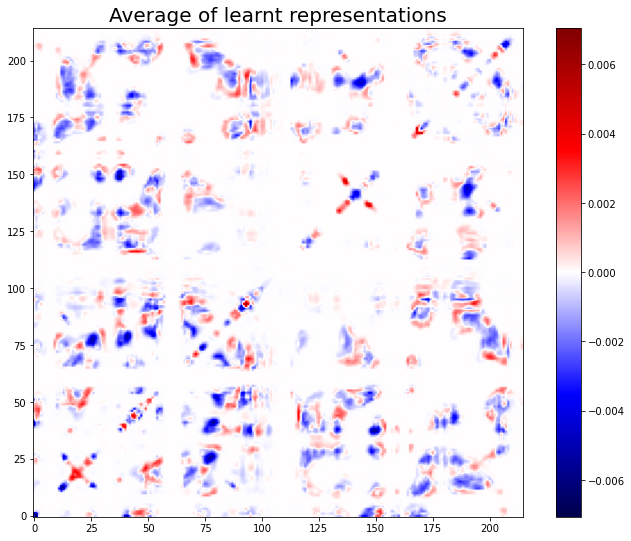

In [3]:
title_size = 20
font_size = 14

fig = plt.figure(figsize=(12, 9))
plt.imshow(cv2.resize(learnt_filter, dsize=(input_shape, input_shape)), origin='lower', cmap='seismic', norm=CenteredNorm())
plt.title('Average of learnt representations', size=title_size)
plt.colorbar()
plt.show()

In [4]:
high_aff = []
low_aff = []
affinity_thr = -8
train_x = preprocessed_data.train_x
train_y = preprocessed_data.train_y

for i in range(train_y.shape[0]):
    if train_y[i] < affinity_thr:
        high_aff.append(train_x[i])
    elif train_y[i] > affinity_thr:
        low_aff.append(train_x[i])

# Obtaining the maps
mean_image = np.mean(train_x, axis=0).reshape(input_shape, input_shape)
mean_diff_image = np.mean(high_aff, axis=0) - np.mean(low_aff, axis=0)

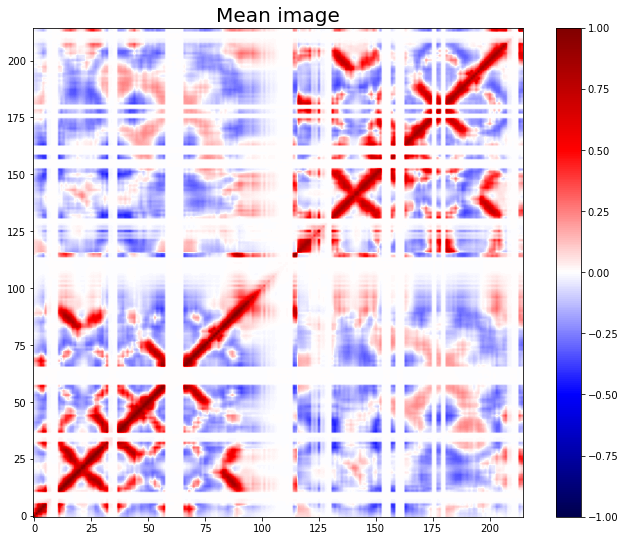

In [5]:
fig = plt.figure(figsize=(12, 9))
plt.imshow(mean_image, origin='lower', cmap='seismic', norm=CenteredNorm())
plt.title('Mean image', size=title_size)
plt.colorbar()
plt.show()

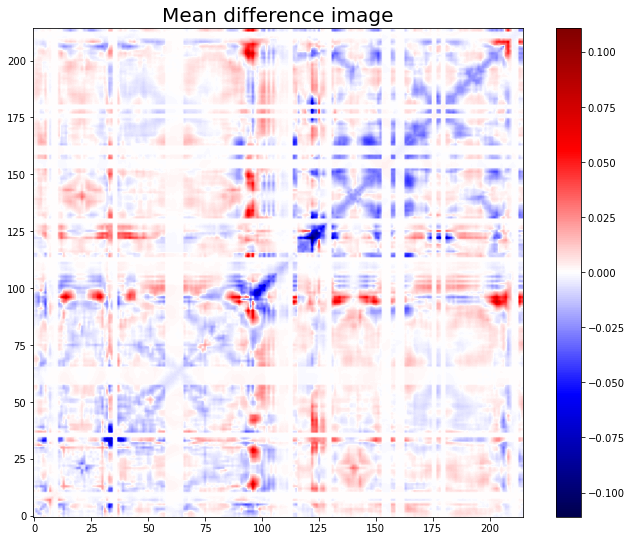

In [6]:
fig = plt.figure(figsize=(12, 9))
plt.imshow(mean_diff_image, origin='lower', cmap='seismic', norm=CenteredNorm())
plt.title('Mean difference image', size=title_size)
plt.colorbar()
plt.show()

# Obtaining $\epsilon$

In [7]:
high_aff = []
low_aff = []
each_img_enl = np.zeros((train_x.shape[0], input_shape, input_shape))
size_le = int(np.sqrt(model.fc1.weight.data.numpy().shape[-1] / n_filters))

for j in range(train_x.shape[0]):
    inter_filter_item = model(torch.from_numpy(train_x[j].reshape(1, 1, input_shape, input_shape).astype(np.float32)))[1].detach().numpy()
    for i in range(n_filters):
        each_img_enl[j] += cv2.resize(np.multiply(inter_filter_item[0,i], model.fc1.weight.data.numpy().reshape(n_filters,size_le**2)[i].reshape(size_le, size_le)), dsize=(input_shape, input_shape))
    high_aff.append(np.multiply(-np.clip(each_img_enl[j], a_min=-np.inf, a_max=0), cv2.resize(train_x[j][0], dsize=(input_shape, input_shape))))
    low_aff.append(np.multiply(np.clip(each_img_enl[j], a_min=0, a_max=np.inf), cv2.resize(train_x[j][0], dsize=(input_shape, input_shape))))

true_filter = deepcopy(np.mean(high_aff, axis=0) - np.mean(low_aff, axis=0))
epsilon = np.multiply(np.abs(np.sign(mean_diff_image[0])), true_filter)

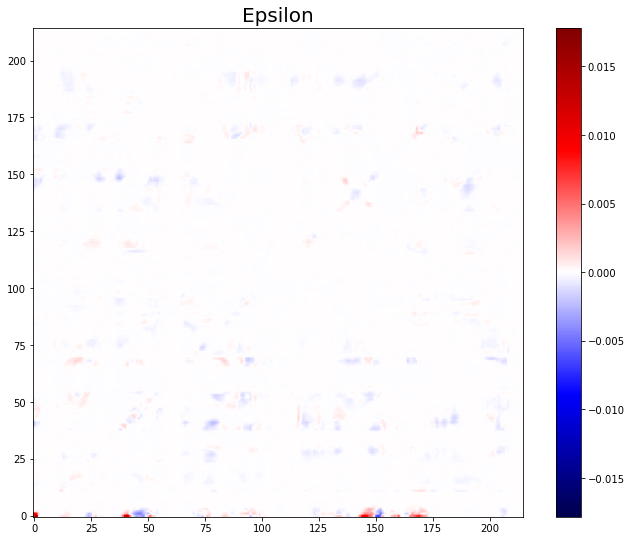

In [8]:
fig = plt.figure(figsize=(12, 9))
plt.imshow(epsilon, origin='lower', cmap='seismic', norm=CenteredNorm())
plt.title('Epsilon', size=title_size)
plt.colorbar()
plt.show()

# Finding correlations between actual strucutres

In [9]:
max_res_list_h = preprocessed_data.max_res_list_h
max_res_list_l = preprocessed_data.max_res_list_l
rmax = np.abs(epsilon).max()

cdr1_coord_h = range(max_res_list_h.index('26'), max_res_list_h.index('33'))
cdr2_coord_h = range(max_res_list_h.index('52'), max_res_list_h.index('57'))
cdr3_coord_h = range(max_res_list_h.index('95'), max_res_list_h.index('102')+1)
beta11_coord_h = range(max_res_list_h.index('33'), max_res_list_h.index('39'))
beta12_coord_h = range(max_res_list_h.index('45'), max_res_list_h.index('51'))
beta13_coord_h = range(max_res_list_h.index('57'), max_res_list_h.index('61'))
beta14_coord_h = range(max_res_list_h.index('89'), max_res_list_h.index('95'))
beta21_coord_h = range(max_res_list_h.index('67'), max_res_list_h.index('72'))
beta22_coord_h = range(max_res_list_h.index('75'), max_res_list_h.index('82'))
alpha_coord_h = range(max_res_list_h.index('84'), max_res_list_h.index('87'))

ticks = [cdr1_coord_h[0], (cdr1_coord_h[-1]+beta11_coord_h[0])/2, beta11_coord_h[-1], beta12_coord_h[0], beta12_coord_h[-1], cdr2_coord_h[0], (cdr2_coord_h[-1]+beta13_coord_h[0])/2, beta13_coord_h[-1], beta21_coord_h[0], beta21_coord_h[-1],
         beta22_coord_h[0], beta22_coord_h[-1], beta14_coord_h[0], (beta14_coord_h[-1]+cdr3_coord_h[0])/2, cdr3_coord_h[-1]]

ticks_labels = ['CDR-H1_i', 'CDR-H1_f & Beta11_i', 'Beta11_f', 'Beta12_i', 'Beta12_f', 'CDR-H2_i', 'CDR-H2_f & Beta13_i', 'Beta13_f', 'Beta21_i', 'Beta21_f', 'Beta22_i', 'Beta22_f', 'Beta14_i', 'Beta14_f & CDR-H3_i', 'CDR-H3_f']

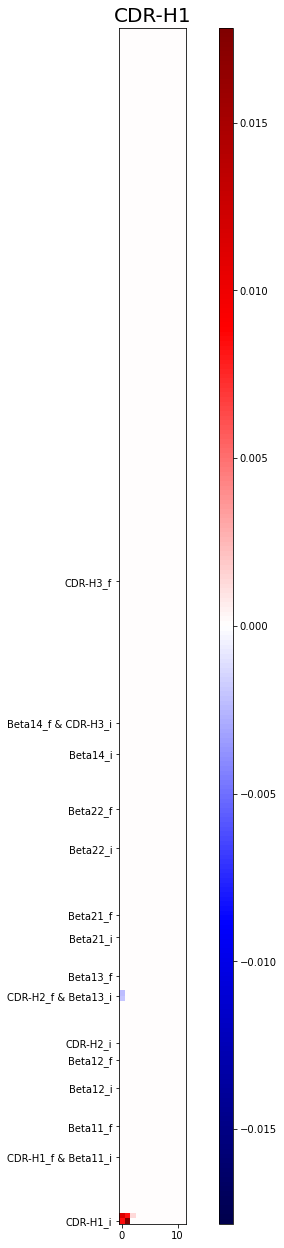

0.01346506739668579


In [10]:
plt.figure(figsize=(12, 22))
cdr1_corr_h = epsilon[:, cdr1_coord_h]
plt.imshow(np.where(abs(cdr1_corr_h)<abs(cdr1_corr_h).max()/15, 0, cdr1_corr_h), origin='lower', cmap='seismic', norm=CenteredNorm(halfrange=rmax))
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar(aspect=90)
plt.title('CDR-H1', size=title_size)
plt.show()
print(cdr1_corr_h.sum())

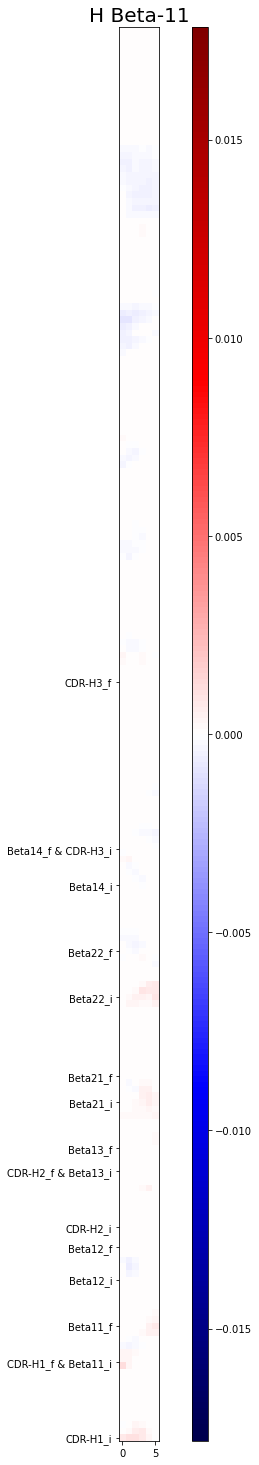

-0.01564671108916641


In [11]:
plt.figure(figsize=(12, 26))
beta11_corr_h = epsilon[:, beta11_coord_h]
plt.imshow(np.where(abs(beta11_corr_h)<abs(beta11_corr_h).max()/15, 0, beta11_corr_h), origin='lower', cmap='seismic', norm=CenteredNorm(halfrange=rmax))
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar(aspect=90)
plt.title('H Beta-11', size=title_size)
plt.show()
print(beta11_corr_h.sum())

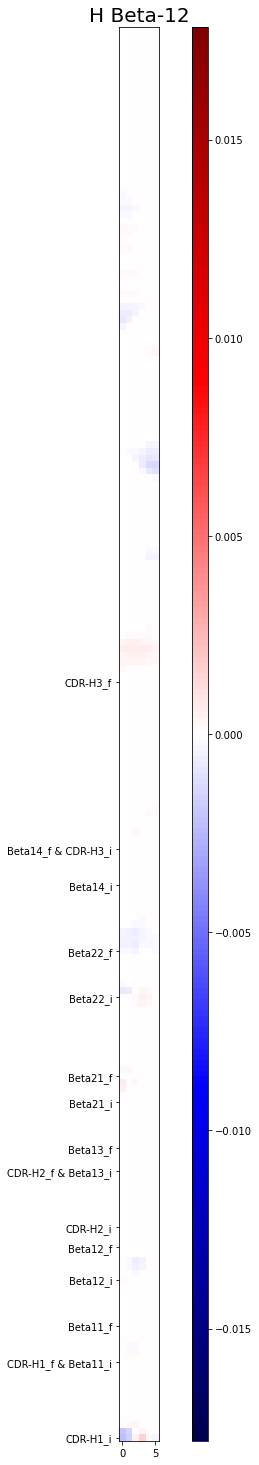

-0.017184700437621207


In [12]:
plt.figure(figsize=(12, 26))
beta12_corr_h = epsilon[:, beta12_coord_h]
plt.imshow(np.where(abs(beta12_corr_h)<abs(beta12_corr_h).max()/15, 0, beta12_corr_h), origin='lower', cmap='seismic', norm=CenteredNorm(halfrange=rmax))
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar(aspect=90)
plt.title('H Beta-12', size=title_size)
plt.show()
print(beta12_corr_h.sum())

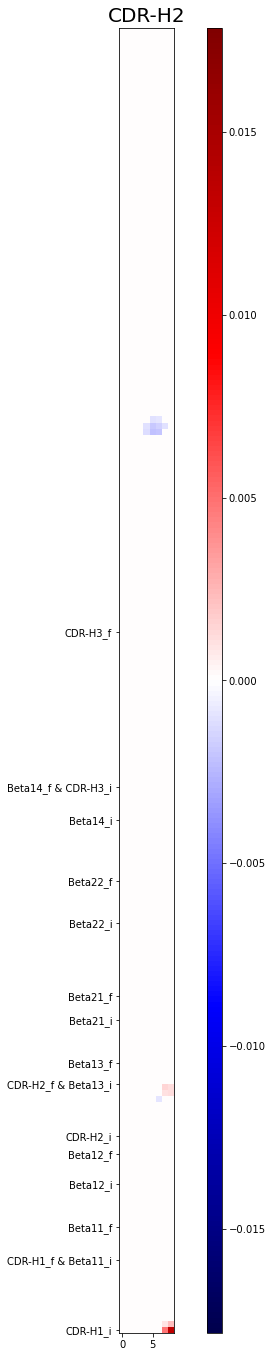

-0.004185583133027264


In [13]:
plt.figure(figsize=(12, 24))
cdr2_corr_h = epsilon[:, cdr2_coord_h]
plt.imshow(np.where(abs(cdr2_corr_h)<abs(cdr2_corr_h).max()/15, 0, cdr2_corr_h), origin='lower', cmap='seismic', norm=CenteredNorm(halfrange=rmax))
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar(aspect=90)
plt.title('CDR-H2', size=title_size)
plt.show()
print(cdr2_corr_h.sum())

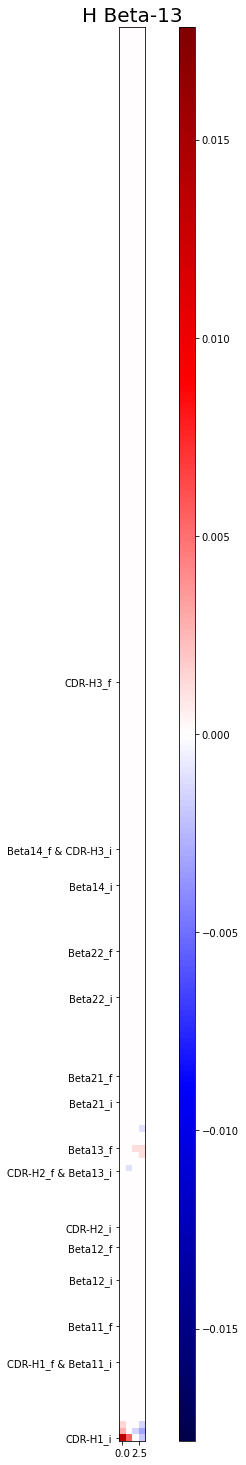

0.02054929801466396


In [14]:
plt.figure(figsize=(12, 26))
beta13_corr_h = epsilon[:, beta13_coord_h]
plt.imshow(np.where(abs(beta13_corr_h)<abs(beta13_corr_h).max()/15, 0, beta13_corr_h), origin='lower', cmap='seismic', norm=CenteredNorm(halfrange=rmax))
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar(aspect=90)
plt.title('H Beta-13', size=title_size)
plt.show()
print(beta13_corr_h.sum())

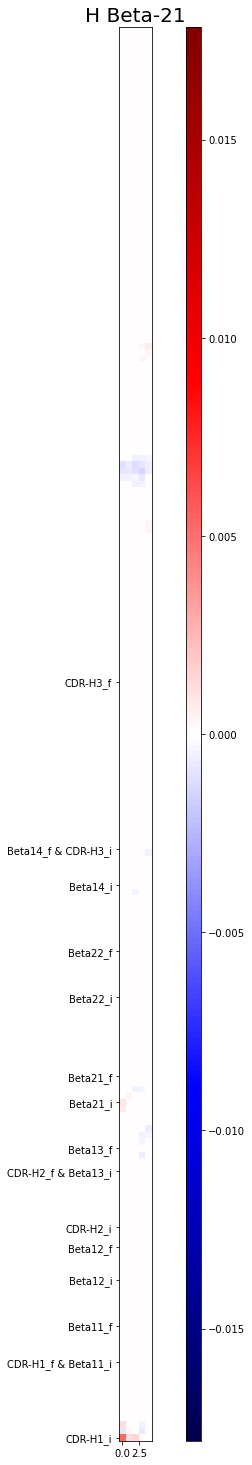

-0.013009113524222408


In [15]:
plt.figure(figsize=(12, 26))
beta21_corr_h = epsilon[:, beta21_coord_h]
plt.imshow(np.where(abs(beta21_corr_h)<abs(beta21_corr_h).max()/15, 0, beta21_corr_h), origin='lower', cmap='seismic', norm=CenteredNorm(halfrange=rmax))
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar(aspect=90)
plt.title('H Beta-21', size=title_size)
plt.show()
print(beta21_corr_h.sum())

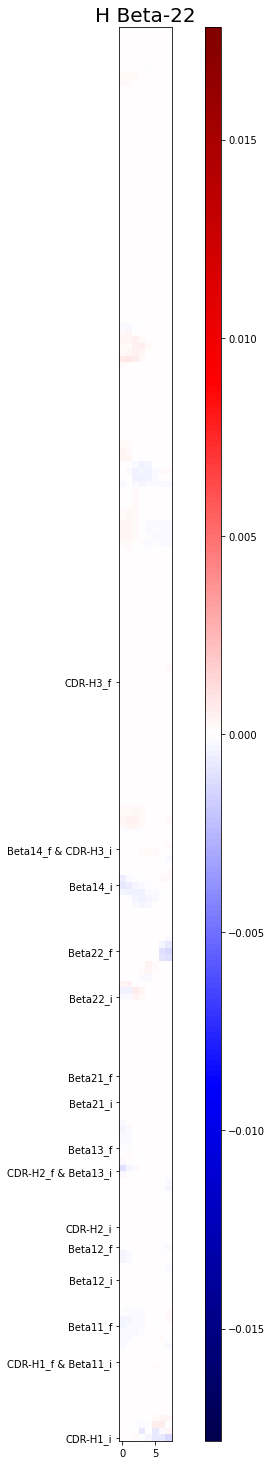

-0.00974862182963617


In [16]:
plt.figure(figsize=(12, 26))
beta22_corr_h = epsilon[:, beta22_coord_h]
plt.imshow(np.where(abs(beta22_corr_h)<abs(beta22_corr_h).max()/15, 0, beta22_corr_h), origin='lower', cmap='seismic', norm=CenteredNorm(halfrange=rmax))
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar(aspect=90)
plt.title('H Beta-22', size=title_size)
plt.show()
print(beta22_corr_h.sum())

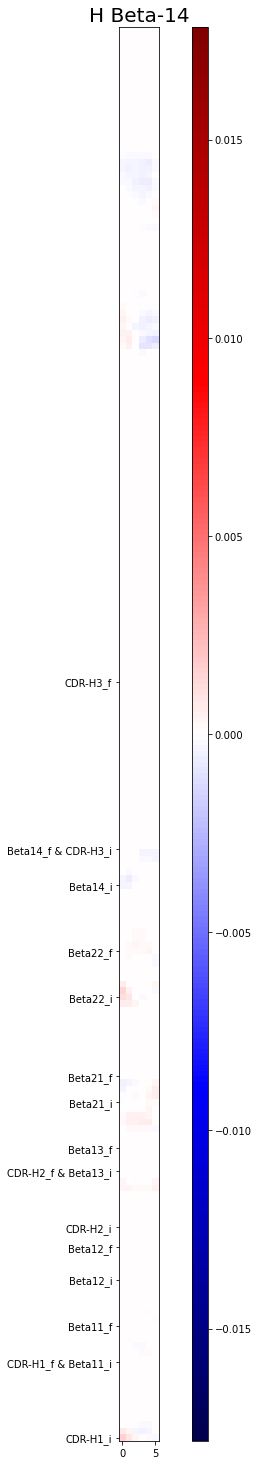

-0.001266360723563599


In [17]:
plt.figure(figsize=(12, 26))
beta14_corr_h = epsilon[:, beta14_coord_h]
plt.imshow(np.where(abs(beta14_corr_h)<abs(beta14_corr_h).max()/15, 0, beta14_corr_h), origin='lower', cmap='seismic', norm=CenteredNorm(halfrange=rmax))
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar(aspect=90)
plt.title('H Beta-14', size=title_size)
plt.show()
print(beta14_corr_h.sum())

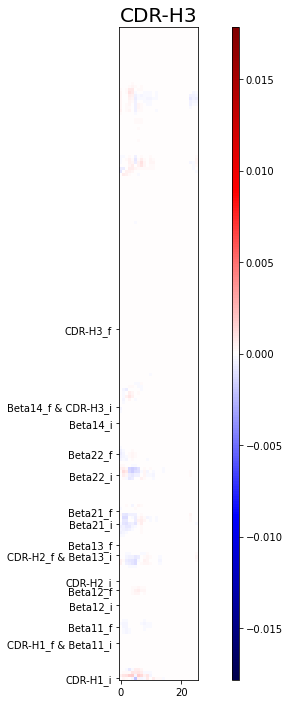

-0.018758396124472995


In [18]:
plt.figure(figsize=(12, 12))
cdr3_corr_h = epsilon[:, cdr3_coord_h]
plt.imshow(np.where(abs(cdr3_corr_h)<abs(cdr3_corr_h).max()/15, 0, cdr3_corr_h), origin='lower', cmap='seismic', norm=CenteredNorm(halfrange=rmax))
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar(aspect=90)
plt.title('CDR-H3', size=title_size)
plt.show()
print(cdr3_corr_h.sum())

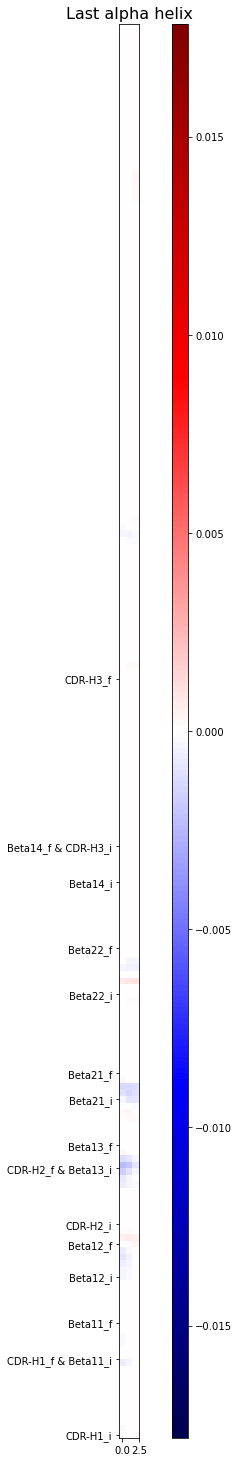

-0.022731335012271075


In [19]:
plt.figure(figsize=(12, 26))
alpha_corr_h = epsilon[:, alpha_coord_h]
plt.imshow(np.where(abs(alpha_corr_h)<abs(alpha_corr_h).max()/15, 0, alpha_corr_h), origin='lower', cmap='seismic', norm=CenteredNorm(halfrange=rmax))
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar(aspect=90)
plt.title('Last alpha helix', size=title_size-4)
plt.show()
print(alpha_corr_h.sum())

# Change in $K_D$ when adding $\epsilon$

In [20]:
# Here it is possible to tune the weight of each antibody region

cdr3_factor_h = 0.1 
cdr1_factor_h = 0.1 
cdr2_factor_h = 0.1 
beta11_factor_h = 0.1 
beta12_factor_h = 0.1 
beta13_factor_h = 0.1 
beta14_factor_h = 0.1 
beta21_factor_h = 0.1 
beta22_factor_h = 0.1 
alpha_factor_h = 0.1 

# Expressing as vectors
weights = np.array([cdr1_factor_h, beta11_factor_h, beta12_factor_h, cdr2_factor_h, beta13_factor_h, beta21_factor_h, beta22_factor_h, alpha_factor_h, beta14_factor_h, cdr3_factor_h])
coord = np.array([cdr1_coord_h, beta11_coord_h, beta12_coord_h, cdr2_coord_h, beta13_coord_h, beta21_coord_h, beta22_coord_h, alpha_coord_h, beta14_coord_h, cdr3_coord_h], dtype=object)
maps = [cdr1_corr_h, beta11_corr_h, beta12_corr_h, cdr2_corr_h, beta13_corr_h, beta21_corr_h, beta22_corr_h, alpha_corr_h, beta14_corr_h, cdr3_corr_h]

# Adding epsilon
ideal = deepcopy(preprocessed_data.test_x)
for i in range(len(weights)):
    temp = deepcopy(np.pad(maps[i], ((0, 0), (coord[i][0], train_x.shape[2]-coord[i][-1]-1))))
    ideal += weights[i] * (temp + np.transpose(temp)) / 2

In [21]:
# Comparing the new Kd w.r.t the original one
prediction = 10**model(torch.from_numpy(preprocessed_data.test_x.reshape(1, 1, input_shape, input_shape).astype(np.float32)))[0].detach().numpy()
new_prediction = 10**model(torch.from_numpy(ideal.reshape(1, 1, input_shape, input_shape).astype(np.float32)))[0].detach().numpy()
per_change = ((prediction - new_prediction) / prediction * 100)[0][0]

print('Without adding epsilon, Kd = ' + str(prediction[0,0]))
print('After adding epsilon, Kd = ' + str(new_prediction[0,0]))
print('Thus, Kd is smaller by', per_change, '%')

Without adding epsilon, Kd = 2.51771e-07
After adding epsilon, Kd = 2.511021e-07
Thus, Kd is smaller by 0.2656799 %
